# P.3. Fitting Yield Curves: Parametric vs. Machine Learning

## 1. Project Statement

Compare parametric yield curve models (Nelson-Siegel) with machine learning approaches (regularized regression, tree-based methods) for fitting the Treasury yield curve. Using 8 years of weekly Treasury data (2018–2025), evaluate each method's ability to price held-out bonds accurately, analyze where and when each approach adds value, investigate how fitting quality varies across market regimes, and verify that fitted curves satisfy basic financial sanity checks.

## 2. Context

### Why Practitioners Care

Yield curve fitting is foundational to fixed income analytics. The discount curve prices all Treasury cashflows and serves as the benchmark for valuing corporate bonds, swaps, and structured products. A small improvement in curve fitting can translate to material differences in portfolio valuation and risk measurement.

The challenge is the **bias-variance tradeoff**. Fitting discount factors directly via OLS leads to extreme multicollinearity—the cashflow matrix has hundreds of columns but high correlation between adjacent dates. This produces discount factors that oscillate wildly and fail on held-out bonds. Parametric models like Nelson-Siegel impose structure (4 parameters instead of hundreds), which stabilizes estimation but may systematically misprice certain maturities.

### Why Raw Bond Quotes?

This project uses raw Treasury quotes from CRSP rather than pre-processed yield curves. Raw quotes contain the real challenges that practitioners face:

- **Market microstructure noise**: Bid-ask spreads, stale quotes, and liquidity effects
- **On-the-run / off-the-run effects**: Recently issued bonds trade at premium prices
- **Coupon effects**: High-coupon bonds may price differently than low-coupon bonds at the same maturity

These features create fitting errors of 5-15 basis points—small but economically meaningful. This is where ML methods might add value by capturing systematic patterns that Nelson-Siegel's smooth functional form cannot.

### The ML Question

Modern machine learning offers regularization techniques (Ridge, Lasso) that can handle high-dimensional, correlated features without the instability of OLS. Tree-based methods (Random Forest, Gradient Boosting) can capture nonlinear patterns that parametric models miss.

The question is whether these methods can provide the flexibility of non-parametric approaches without overfitting. This project investigates when and where ML adds value over the parsimonious Nelson-Siegel model.

### Key Concepts

**Nelson-Siegel model:** The spot rate at maturity $\tau$ is:

$$r(\tau) = \beta_0 + \beta_1 \frac{1-e^{-\tau/\lambda}}{\tau/\lambda} + \beta_2 \left(\frac{1-e^{-\tau/\lambda}}{\tau/\lambda} - e^{-\tau/\lambda}\right)$$

The parameters have economic interpretations:
- $\beta_0$: Long-run level (loading approaches 1 as $\tau \to \infty$)
- $\beta_1$: Short-run deviation (loading is 1 at $\tau=0$, decays to 0)
- $\beta_2$: Curvature (hump-shaped loading, peaks at medium maturities)
- $\lambda$: Decay rate controlling where the curvature peaks

**Hold-out validation:** Splitting bonds into training and test sets each day allows genuine out-of-sample evaluation. Training RMSE alone can be misleading—a model that memorizes noise will have low training error but high test error.

**Financial sanity checks:** A fitted curve should produce:
- Positive discount factors at all maturities
- Discount factors that decrease with maturity
- Forward rates that are positive and reasonably bounded

## 3. Resources

### Course Materials

| Material | Relevance |
|----------|----------|
| **D.1.1 The Spot Discount Curve** | Bootstrap, OLS multicollinearity, Nelson-Siegel model, pricing with discount factors |
| **E.1.1 Estimating the Spot Curve** | Hands-on NS fitting, cashflow matrix construction, model comparison |
| **D.3.3 Discount via SOFR Futures** | Alternative curve construction from futures prices |

### External Reading

- [Federal Reserve: GSW Yield Curve Methodology](https://www.federalreserve.gov/pubs/feds/2006/200628/200628abs.html) — How the Fed fits the Treasury curve
- [BIS: Zero-Coupon Yield Curves](https://www.bis.org/publ/bppdf/bispap25.htm) — Central bank practices for curve estimation
- [scikit-learn: Ridge Regression](https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression) — Regularized linear models documentation

### Data Files

| File | Description | Frequency | Date Range |
|------|-------------|-----------|------------|
| `treasury_panel_weekly.xlsx` | CRSP Treasury quotes panel | Weekly | 2018–2025 |
| `gsw_yields.xlsx` | GSW zero-coupon yields (30 maturities) | Daily | 1961–2025 |

The Treasury panel contains ~350 bonds per week across 418 weekly snapshots, covering key market regimes including the 2019 yield curve inversion, COVID crisis (2020), Fed hiking cycle (2022–23), and SVB banking stress (2023). The GSW yields provide a widely-used benchmark curve from the Federal Reserve.

**Panel columns**: `quote date`, `kytreasno`, `tcusip`, `type`, `issue date`, `maturity date`, `ttm`, `cpn rate`, `bid`, `ask`, `price`, `accrued int`, `dirty price`, `ytm`, `duration`

### Additional Data Sources (Optional)

- **FRED:** Public H.15 Treasury constant maturity rates as a cross-check.

## 4. Data Preview

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 5)

In [2]:
# Load the weekly Treasury panel
panel = pd.read_excel('data/treasury_panel_weekly.xlsx', sheet_name='panel')
panel['quote date'] = pd.to_datetime(panel['quote date'])

print(f"Panel shape: {panel.shape}")
print(f"Date range: {panel['quote date'].min().date()} to {panel['quote date'].max().date()}")
print(f"Number of weeks: {panel['quote date'].nunique()}")
print(f"\nBonds per week: {panel.groupby('quote date').size().mean():.0f} (avg)")

Panel shape: (156251, 16)
Date range: 2018-01-05 to 2025-12-31
Number of weeks: 418

Bonds per week: 374 (avg)


In [3]:
# Filter to nominal securities (exclude TIPS)
def filter_nominal(df):
    """Filter to nominal Treasuries suitable for curve fitting."""
    data = df.copy()
    data = data[~data['type'].str.contains('TIPS', case=False, na=False)].copy()
    data = data[(data['ytm'] > 0) & (data['ttm'] > 0.25) & (data['ttm'] <= 30)].copy()
    return data

panel_nominal = filter_nominal(panel)
print(f"Nominal securities: {len(panel_nominal):,} records")
print(f"Security types: {panel_nominal['type'].value_counts().to_dict()}")

Nominal securities: 140,946 records
Security types: {'note': 95119, 'bond': 35571, 'bill': 10256}


In [4]:
# Select a sample date for initial exploration
sample_date = panel_nominal['quote date'].max()
quotes = panel_nominal[panel_nominal['quote date'] == sample_date].copy()

print(f"Sample date: {sample_date.date()}")
print(f"Number of bonds: {len(quotes)}")
print(f"Maturity range: {quotes['ttm'].min():.2f} to {quotes['ttm'].max():.2f} years")
quotes[['type', 'ttm', 'cpn rate', 'ytm', 'price']].head(10)

Sample date: 2025-12-31
Number of bonds: 362
Maturity range: 0.25 to 29.87 years


,type,ttm,cpn rate,ytm,price
155889,bill,0.251882,0.000,0.035693,99.112854
155890,bill,0.265572,0.000,0.035336,99.074094
155891,bill,0.271047,0.000,0.035787,99.043185
155892,bill,0.284736,0.000,0.035474,99.003785
155893,note,0.287474,3.750,0.035575,100.054229
155894,bill,0.290212,0.000,0.035502,98.983927
155895,bill,0.303901,0.000,0.035558,98.934589
155896,bill,0.309377,0.000,0.035577,98.914926
155897,bill,0.323066,0.000,0.035548,98.868107
155898,note,0.328542,2.375,0.035188,99.634296


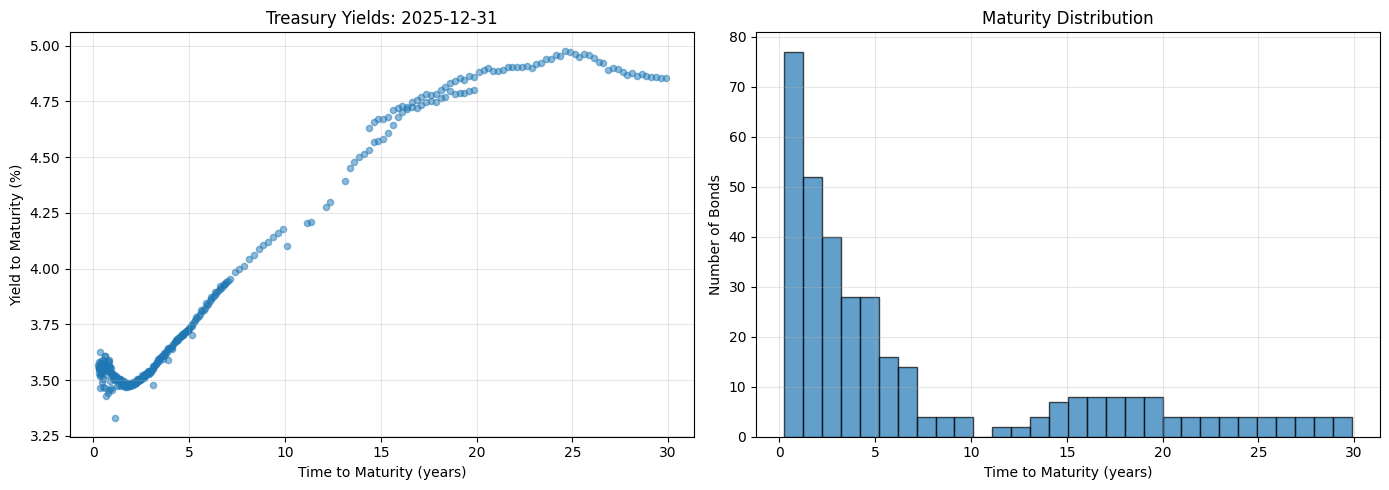

In [5]:
# Plot yields by maturity for sample date
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Yield vs maturity
axes[0].scatter(quotes['ttm'], quotes['ytm'] * 100, alpha=0.5, s=20)
axes[0].set_xlabel('Time to Maturity (years)')
axes[0].set_ylabel('Yield to Maturity (%)')
axes[0].set_title(f'Treasury Yields: {sample_date.date()}')
axes[0].grid(True, alpha=0.3)

# Distribution of maturities
axes[1].hist(quotes['ttm'], bins=30, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Time to Maturity (years)')
axes[1].set_ylabel('Number of Bonds')
axes[1].set_title('Maturity Distribution')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

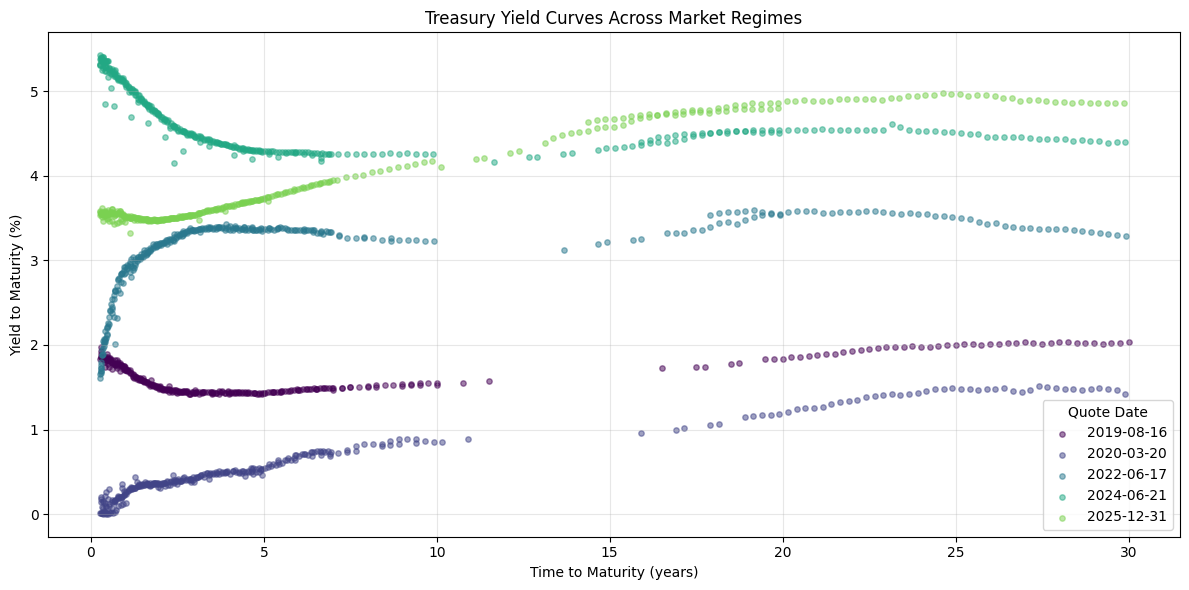

In [6]:
# Visualize yield curves across different regimes
# Show: pre-COVID, COVID trough, hiking cycle, recent
sample_dates_target = ['2019-08-15', '2020-03-20', '2022-06-15', '2024-06-15']
all_dates = panel_nominal['quote date'].drop_duplicates().sort_values()

# Add the most recent available date
latest_date = all_dates.max()
sample_dates_target.append(latest_date.strftime('%Y-%m-%d'))

fig, ax = plt.subplots(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0, 0.8, len(sample_dates_target)))

for i, target in enumerate(sample_dates_target):
    target_ts = pd.Timestamp(target)
    # Find nearest available date
    idx = all_dates.searchsorted(target_ts)
    if idx >= len(all_dates):
        idx = len(all_dates) - 1
    date = all_dates.iloc[idx]
    data = panel_nominal[panel_nominal['quote date'] == date]
    ax.scatter(data['ttm'], data['ytm'] * 100, 
               alpha=0.5, s=15, c=[colors[i]], label=date.strftime('%Y-%m-%d'))

ax.set_xlabel('Time to Maturity (years)')
ax.set_ylabel('Yield to Maturity (%)')
ax.set_title('Treasury Yield Curves Across Market Regimes')
ax.legend(title='Quote Date')
ax.grid(True, alpha=0.3)
plt.tight_layout()

### Nelson-Siegel: The Model

The Nelson-Siegel yield curve is defined by three factor loadings that depend on maturity $\tau$ and a decay parameter $\lambda$:

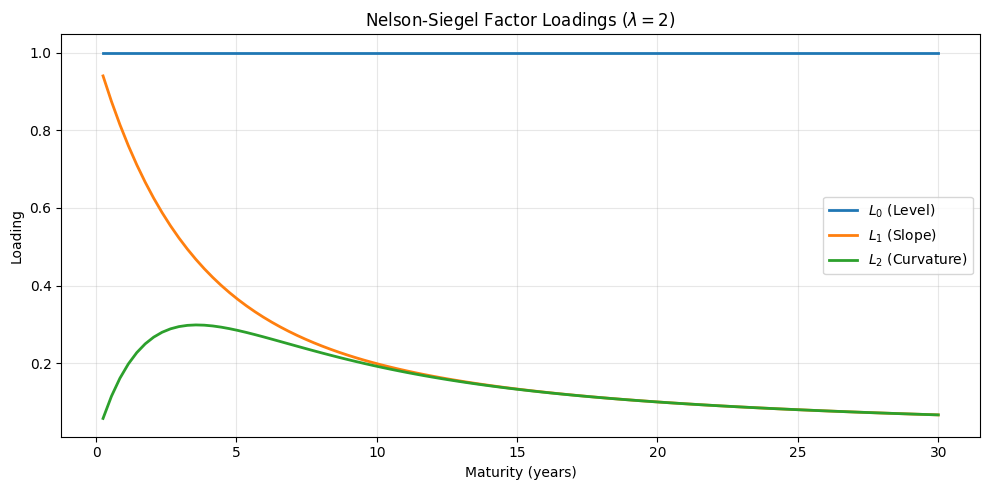

In [7]:
def nelson_siegel_yield(tau, beta0, beta1, beta2, lam):
    """Compute Nelson-Siegel yield at maturity tau."""
    tau = np.asarray(tau)
    tau_scaled = tau / lam
    tau_scaled = np.maximum(tau_scaled, 1e-6)  # Avoid division by zero
    
    exp_term = np.exp(-tau_scaled)
    L1 = (1 - exp_term) / tau_scaled
    L2 = L1 - exp_term
    
    return beta0 + beta1 * L1 + beta2 * L2


# Visualize factor loadings
tau_grid = np.linspace(0.25, 30, 100)
lam = 2.0
tau_scaled = tau_grid / lam
exp_term = np.exp(-tau_scaled)
L0 = np.ones_like(tau_grid)
L1 = (1 - exp_term) / tau_scaled
L2 = L1 - exp_term

plt.figure(figsize=(10, 5))
plt.plot(tau_grid, L0, label=r'$L_0$ (Level)', linewidth=2)
plt.plot(tau_grid, L1, label=r'$L_1$ (Slope)', linewidth=2)
plt.plot(tau_grid, L2, label=r'$L_2$ (Curvature)', linewidth=2)
plt.xlabel('Maturity (years)')
plt.ylabel('Loading')
plt.title(r'Nelson-Siegel Factor Loadings ($\lambda = 2$)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

### Illustration: Plugging in Parameters

To see how NS works, we can plug in some reasonable parameters and compare to observed yields:

RMSE with illustrative parameters: 33.9 bps

Your task in Q1: find parameters that minimize this RMSE.


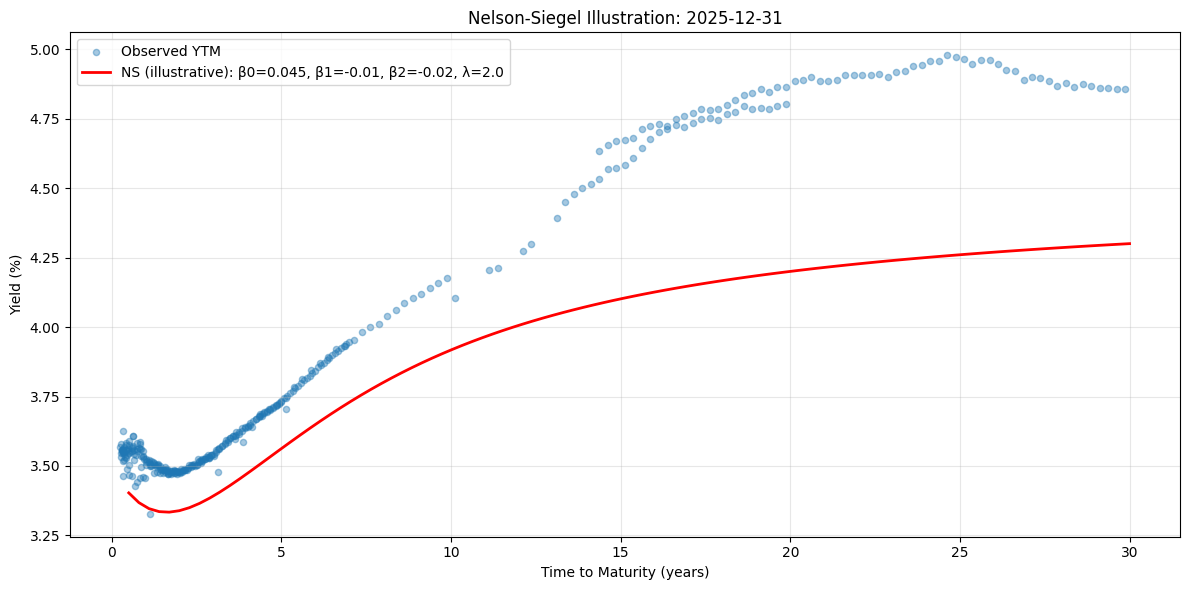

In [13]:
# Illustrative parameters (you will fit these properly in Q1)
beta0_guess = 0.045  # Long-run level ~4.5%
beta1_guess = -0.01  # Slope (negative = upward sloping curve)
beta2_guess = -0.02  # Curvature
lam_guess = 2.0      # Decay parameter

# Compute NS curve with these parameters
tau_grid = np.linspace(0.5, 30, 100)
ns_yields = nelson_siegel_yield(tau_grid, beta0_guess, beta1_guess, beta2_guess, lam_guess)

# Plot against actual data
plt.figure(figsize=(12, 6))
plt.scatter(quotes['ttm'], quotes['ytm'] * 100, alpha=0.4, s=20, label='Observed YTM')
plt.plot(tau_grid, ns_yields * 100, 'r-', linewidth=2, 
         label=f'NS (illustrative): β0={beta0_guess}, β1={beta1_guess}, β2={beta2_guess}, λ={lam_guess}')
plt.xlabel('Time to Maturity (years)')
plt.ylabel('Yield (%)')
plt.title(f'Nelson-Siegel Illustration: {sample_date.date()}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Compute RMSE for this guess
ns_at_bonds = nelson_siegel_yield(quotes['ttm'].values, beta0_guess, beta1_guess, beta2_guess, lam_guess)
rmse = np.sqrt(np.mean((quotes['ytm'].values - ns_at_bonds) ** 2))
print(f"RMSE with illustrative parameters: {rmse * 10000:.1f} bps")
print(f"\nYour task in Q1: find parameters that minimize this RMSE.")

## 5. Questions

### Question 1: Nelson-Siegel Baseline

**Establish the Nelson-Siegel model as a baseline for comparison.**

a) Using one cross-section of Treasury quotes from the panel, fit the Nelson-Siegel model by minimizing the sum of squared yield errors. Report the fitted parameters $(\beta_0, \beta_1, \beta_2, \lambda)$ and the in-sample RMSE (in basis points).

RMSE with fitted parameters: 4.4 bp compared to 33.9 bps with illustrative parameters.


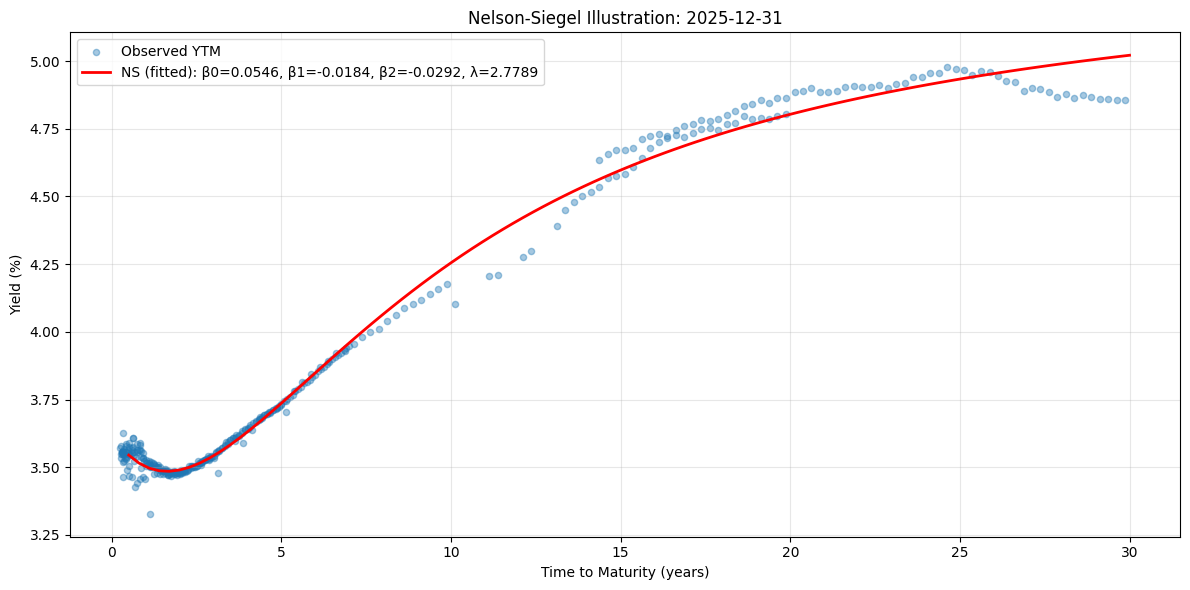

In [15]:
def fit_nelson_siegel(quotes):
    # Fit NS parameters
    def objective(params):
        beta0, beta1, beta2, lam = params
        ns_at_bonds = nelson_siegel_yield(quotes['ttm'].values, beta0, beta1, beta2, lam)
        return np.sqrt(np.mean((quotes['ytm'].values - ns_at_bonds) ** 2))
    
    # Initial guess
    initial_guess = [0.04, -0.01, -0.02, 2.0]
    bounds = [(0, 0.1), (-0.05, 0), (-0.05, 0), (0.1, 10)]
    result = minimize(objective, initial_guess, bounds=bounds)
    return result.x, result.fun

sample_data = quotes.copy()
params, rmse_fit = fit_nelson_siegel(sample_data)

beta0_fit = params[0]
beta1_fit = params[1]
beta2_fit = params[2]
lam_fit = params[3]

tau_grid = np.linspace(0.5, 30, 100)
ns_yields = nelson_siegel_yield(tau_grid, beta0_fit, beta1_fit, beta2_fit, lam_fit)

plt.figure(figsize=(12, 6))
plt.scatter(quotes['ttm'], quotes['ytm'] * 100, alpha=0.4, s=20, label='Observed YTM')
plt.plot(tau_grid, ns_yields * 100, 'r-', linewidth=2, 
         label=f'NS (fitted): β0={round(beta0_fit, 4)}, β1={round(beta1_fit, 4)}, β2={round(beta2_fit, 4)}, λ={round(lam_fit, 4)}')
plt.xlabel('Time to Maturity (years)')
plt.ylabel('Yield (%)')
plt.title(f'Nelson-Siegel Illustration: {sample_date.date()}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

ns_at_bonds = nelson_siegel_yield(quotes['ttm'].values, beta0_fit, beta1_fit, beta2_fit, lam_fit)
rmse_fit = np.sqrt(np.mean((quotes['ytm'].values - ns_at_bonds) ** 2))
print(f"RMSE with fitted parameters: {rmse_fit * 10000:.1f} bp compared to {rmse * 10000:.1f} bps with illustrative parameters.")

b) Plot the fitted yield curve against the observed bond yields. Identify regions where NS fits well and where it systematically over- or under-predicts.

After plotting the fitted NS parameters we can see from the data that the curve has too large deviations. First, NS overstates yields in the belly of the curve. Second, we appear to not capture the curvature far out the curve, and as such, longer maturities are overstated.

c) Convert your fitted spot curve to discount factors. Verify they are positive and decreasing in maturity.


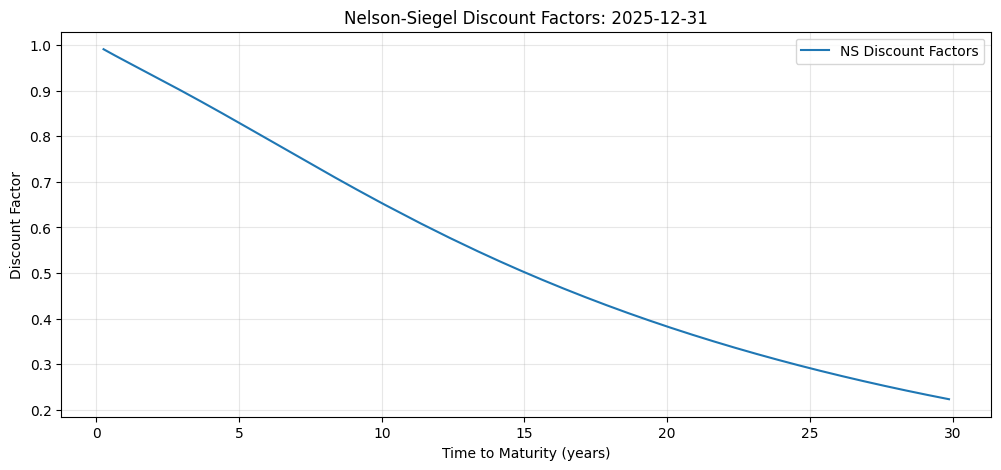

Given that the minimum is above 0 and the maximum is below 1, and the curve visually declines, all discount factors are valid.
Minimum discount factor: 0.223258
Maximum discount factor: 0.991027


In [30]:
ns_discount_factors = np.exp(-ns_at_bonds * quotes['ttm'].values)
plt.figure(figsize=(12, 5))
plt.plot(quotes['ttm'], ns_discount_factors, '-', label='NS Discount Factors')
plt.xlabel('Time to Maturity (years)')
plt.ylabel('Discount Factor')
plt.title(f'Nelson-Siegel Discount Factors: {sample_date.date()}')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
print('Given that the minimum is above 0 and the maximum is below 1, and the curve visually declines, all discount factors are valid.')
print(f'Minimum discount factor: {min(ns_discount_factors):.6f}')
print(f'Maximum discount factor: {max(ns_discount_factors):.6f}')

### Question 2: Hold-Out Validation Framework

**Implement cross-validation to measure true out-of-sample performance.**

a) For a single date, randomly split bonds into 80% training and 20% test sets. Consider stratifying by maturity bucket (short, medium, long) to ensure the test set spans the curve.

b) Fit Nelson-Siegel on the training bonds only. Use the fitted curve to predict yields for the test bonds. Report:
   - Training RMSE
   - Test RMSE
   - Ratio of test to training RMSE (values much greater than 1 suggest overfitting)

c) Repeat the train/test split 10 times with different random seeds. Report the mean and standard deviation of test RMSE across splits. Is NS performance stable?

d) **Time-series analysis**: Using the weekly panel, fit NS to at least 50 dates spanning different market regimes (e.g., 2019 inversion, 2020 COVID, 2022-24 hiking cycle, 2023 SVB stress). Plot test RMSE over time. Identify periods where fitting is harder—what characterizes these periods? Consider:
   - Yield level and curve shape
   - Market volatility
   - Number of bonds available

### Question 3: ML Alternatives

**Compare machine learning methods to Nelson-Siegel using the same out-of-sample framework.**

Implement at least **two** of the following approaches:

1. **Ridge Regression**: Use polynomial features of maturity (e.g., $\tau, \tau^2, \tau^3, \ldots$) and/or NS-like loadings as features. Tune the regularization parameter $\alpha$ via cross-validation.

2. **Lasso Regression**: Same features as Ridge. Lasso performs feature selection—which polynomial terms does it keep?

3. **Random Forest**: Predict yield from maturity (and optionally coupon rate). Use out-of-bag error or cross-validation for hyperparameter tuning.

4. **Gradient Boosting (XGBoost or sklearn)**: Similar setup to Random Forest. Compare performance and training time.

For each method:

a) Apply the **same hold-out validation framework** from Q2 (80/20 split, same random seeds). This ensures a fair head-to-head comparison with NS on identical train/test splits.

b) Report training RMSE, test RMSE, and percentage improvement over NS on the **same test set**.

c) Create a summary table comparing all methods across multiple dates spanning different regimes. For each date, report which method wins on the held-out test set.

d) Which method performs best out-of-sample? Is the winner consistent across dates and regimes, or does it depend on market conditions?

### Question 4: Maturity Segment Analysis

**Investigate where ML methods add value.**

a) Segment test bonds into three buckets:
   - Short: $\tau < 2$ years
   - Medium: $2 \leq \tau \leq 10$ years
   - Long: $\tau > 10$ years

b) For Nelson-Siegel and your best ML method, report test RMSE separately for each maturity segment.

c) Create a bar chart or table showing the performance gap (NS RMSE minus ML RMSE) by segment. Where does ML improve most?

d) Propose an explanation for the pattern you observe. Consider:
   - Which part of the curve has more bonds (more data for ML to learn from)?
   - Which part of the curve is the NS functional form best suited for?
   - Are there systematic patterns (e.g., on-the-run/off-the-run effects) that ML might capture?

### Question 5: Financial Sanity Checks

**Verify that fitted curves are economically sensible.**

A curve that minimizes pricing errors but violates no-arbitrage conditions is not useful for trading.

a) For Nelson-Siegel and your ML methods, compute on a **dense maturity grid** (e.g., 100+ points from 0.5 to 30 years):
   - Fitted zero-coupon yields (spot rates)
   - Implied discount factors: $Z(\tau) = e^{-r(\tau) \cdot \tau}$
   - Implied instantaneous forward rates: $f(\tau) = -\frac{d \ln Z(\tau)}{d\tau}$ (use finite differences)

b) Check the following sanity conditions:
   - Are all discount factors positive?
   - Are discount factors strictly decreasing in maturity?
   - Are all forward rates positive?
   - Are forward rates within a reasonable range (e.g., between -2% and 15%)?
   - **Are forward rates smooth?** (e.g., no jumps larger than 50 bps between adjacent grid points)

c) Plot the forward rate curves for NS vs. your ML methods on the same graph. Does NS produce a smoother forward curve? Why might forward rate smoothness matter for trading applications?

d) If your ML method produces violations (especially choppy forward rates), propose a fix. Options include:
   - Post-hoc monotonicity adjustment
   - Constrained optimization
   - Using NS-like basis functions as features (inheriting smoothness)

Discuss the tradeoff: enforcing constraints may increase fitting error but produces more usable curves.

*Hint: A sparse grid (e.g., just 7 standard maturities) may hide problems that become obvious on a dense grid. Forward rates amplify any non-smoothness in the spot curve.*

### Question 6: GSW Yields as a Benchmark

**Compare your fitting methods on GSW yields vs. raw Treasury quotes.**

The Gürkaynak-Sack-Wright (GSW) dataset is published by the Federal Reserve and widely used in academic research and by practitioners. It provides daily zero-coupon yields at standard maturities.

a) Using `gsw_yields.xlsx`, extract yields for the same date as one of your Treasury snapshots. Fit both Nelson-Siegel and a regularized model (e.g., Ridge with polynomial features) to the GSW curve (use the yields at maturities 1, 2, 3, 5, 7, 10, 20, 30 years as your observations).

b) Compare the fitting errors (RMSE) between:
   - NS fitted to GSW yields
   - NS fitted to raw Treasury quotes
   - ML fitted to GSW yields
   - ML fitted to raw Treasury quotes

c) Investigate how the GSW dataset is constructed (see the Federal Reserve documentation in Resources). Based on your findings:
   - Which dataset provides a more meaningful test of curve-fitting methods? Why?
   - What are the pros and cons of using GSW vs. raw bond data for yield curve analysis?

d) Synthesize your findings from Q4–Q6: If you were building a production system for pricing bonds, what approach would you recommend? Consider:
   - Choice of fitting method (NS, ML, or hybrid)
   - Choice of calibration data (GSW vs. raw quotes)
   - How your recommendation might differ for a trading desk vs. academic research

### Question 7: Optimization Robustness

**Investigate the reliability of your NS optimization across different market conditions.**

Nelson-Siegel fitting involves nonlinear optimization, which can be sensitive to initial values, optimizer choice, and the structure of the data.

a) Using your optimizer from Q1, fit NS to the following dates and report the fitted parameters and RMSE:
   - A "normal" date (e.g., mid-2024)
   - March 2020 (COVID volatility)
   - March 2023 (SVB / banking stress)
   - August 2019 (yield curve inversion—the 2s10s spread went negative)

b) For each date, try at least **three different initial guesses** for $(\beta_0, \beta_1, \beta_2, \lambda)$. Do you converge to the same solution? If not, which solution has lower RMSE?

c) Experiment with your optimization approach:
   - Try different optimizers available in `scipy.optimize`
   - Try adding bounds on parameters
   - Try fixing $\lambda$ at a constant value (e.g., 1.5 or 2.0) and only optimizing $(\beta_0, \beta_1, \beta_2)$—note that this makes the problem linear!
   
   Which approach produces the most reliable results across dates?

d) Based on your experiments, what recommendations would you make for fitting NS in production? Consider:
   - How to choose initial values
   - Whether to fix or estimate $\lambda$
   - How to detect when the optimizer may have found a poor local minimum

### Question 8: Parameter Stability Across Time

**Analyze how Nelson-Siegel parameters behave over time and under stress.**

The panel data enables analysis of how the NS model behaves dynamically—something not possible with isolated snapshots.

a) Fit Nelson-Siegel to weekly data from 2018–2024. Extract the time series of $(\beta_0, \beta_1, \beta_2, \lambda)$.

b) Plot each parameter over time. Answer:
   - How stable is $\lambda$ (the decay parameter)? Should it be fixed or estimated freely?
   - Do the interpretations of $\beta_0$ as "level" and $\beta_1$ as "slope" hold empirically? Compare $\beta_0$ to the 10-year yield and $\beta_1$ to the 2s10s spread.

c) Focus on two stress periods:
   - **COVID (March 2020)**: Extreme volatility, flight to quality
   - **SVB collapse (March 2023)**: Banking stress, curve inversion

   For each period, examine:
   - How did parameters change week-over-week?
   - Did $\lambda$ become unstable (e.g., hitting bounds or jumping erratically)?
   - Did fitting RMSE increase during stress?

d) Based on your analysis, discuss:
   - Is NS robust enough for production use during market stress?
   - Would fixing $\lambda$ at a constant value improve stability? At what cost to fit quality?